In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import resample
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None 

In [2]:
df = pd.read_csv(r'/Users/tsaichao-yi/Downloads/Parking_Violations_Issued_-_Fiscal_Year_2015.csv')  

/var/folders/6d/_t56tgqs5rb4zjpyv64nnjvc0000gn/T/ipykernel_1918/442458610.py:1: DtypeWarning: Columns (18,29,38,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'/Users/tsaichao-yi/Downloads/Parking_Violations_Issued_-_Fiscal_Year_2015.csv')


Since the data size is almost 3GB, it would be difficult to train. I decided to focus on cases in which the issue dates of the plates were in the first half year of 2014. 

In [3]:
year = [int(w[6:])==2014 for w in df['Issue Date']]
month = [7>int(w[:2])>0 for w in df['Issue Date']]
df1 = df[[a and b for a, b in zip(year, month)]]

The first step is removing variables with more than 30% missing values since any imputation method could not provide a reliable result.

In [4]:
def missing(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
    return missing_value_df
lost = missing(df1)['percent_missing'] > 0.3
df1 = df1[df1.columns[~lost]]

Here, I deleted several noninformative variables and extracted the partitions of attributes as the new ones, including 'Issue Day', 'Vehicle Expiration Year', 'Violation Hour', and 'Violation Minute'. Then, I replaced the outliers in features with null values. These will be imputed later.

In [5]:
pre_hour = [str(w)[:2] for w in list(df1['Violation Time']) ]
df1['Violation Hour'] = pd.Series([(int(w) if 0<=int(w)<=24 else np.NaN) if w.isdigit() else np.NaN for w in pre_hour])
pre_minute = [str(w)[2:4] for w in list(df1['Violation Time']) ]
df1['Violation Minute'] = pd.Series([(int(w) if 0<=int(w)<=60 else np.NaN) if w.isdigit() else np.NaN for w in pre_minute])
df1['Issue Day'] = pd.Series([int(w[:2]) for w in list(df1['Issue Date'])])
df1['Vehicle Expiration Year'] = pd.Series([int(w[6:10]) for w in list(df1['Vehicle Expiration Date'])])
df1.replace({'Vehicle Expiration Year' : { 8888 :  np.NaN, 1:np.NaN}}, inplace=True)
df1.replace({'Vehicle Year': {0 : np.NaN}}, inplace=True)
df1.drop(['Summons Number', 'Plate ID', 'Date First Observed', 'Violation Time', 
          'Issue Date', 'Vehicle Expiration Date', 'Sub Division'], axis=1, inplace=True)

To avoid plate types not found in the testing data, I picked their unique values to generate the label encoding scheme.

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
key_target = le.fit(list(set(df1['Plate Type'])))

Split 80% of the data into the training data set and the rest into the testing data.

In [7]:
cont_feats = [col for col in df1.columns if col!='Plate Type']
X_train, X_test, y_train, y_test = train_test_split(
     df1[cont_feats], df1['Plate Type'], test_size=0.2, random_state=0)
train = X_train.join(y_train)
test = X_test.join(y_test)

Transformed the outcome variable into a dummy variable.

In [8]:
target = key_target.transform(train['Plate Type'])

Split the training data into categorical and numeric dataframes.

In [9]:
num_cols = train._get_numeric_data().columns
feats = list(set(df1.columns) - set(num_cols))
feats.remove('Plate Type')
category = train[feats] 

Replaced the missing values with the most frequent class in each column in the categorical dataframe.

In [10]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
category_imputed = imp_mean.fit_transform(category)
df_category_imputed = pd.DataFrame(category_imputed, columns=list(category))
df_category_imputed.reset_index(inplace=True, drop=True)

To prevent the noise from the infrequent classes from harming the prediction performance, elements whose percentage in each column was less than 20% were replaced with a new class 'other'.

In [11]:
limit = round(train.shape[0]*0.2)
new_category = df_category_imputed.where(
    category.apply(lambda x: x.map(x.value_counts()))>=limit, 'other')

Utilized one hot encoder to transform the categorical data frame. Note that to avoid the unseen case in the testing data, the handle_unknown parameter is set to 'ignore'.

In [12]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(handle_unknown='ignore')
key = onehot.fit(new_category)
onehot_result = key.transform(new_category).toarray()
onehot_back = pd.DataFrame(onehot_result, columns=onehot.get_feature_names_out())

Removed the columns containing single values.

In [13]:
for col in new_category.columns:
    if len(new_category[col].unique()) == 1:
        new_category.drop(col,inplace=True,axis=1)

Similarily, I replaced the missing values with the most frequent class in each column in the numeric dataframe.

In [14]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
numeric_imputed = imp_mean.fit_transform(train[num_cols])
df_numeric_imputed = pd.DataFrame(numeric_imputed, columns=list(num_cols))
df_numeric_imputed.reset_index(inplace=True, drop=True)

Deleted numeric columns whose variances were close to zero.

In [15]:
selector = VarianceThreshold(threshold=.003)
normalized_df = df_numeric_imputed / df_numeric_imputed.mean()
_ = selector.fit(normalized_df)
mask = selector.get_support()
df_select = df_numeric_imputed.loc[:, mask]

Because I will use logistic regression for prediction, I dealt with the multicollinearity problem by filtering highly correlated predictors. I set the threshold to 0.75 to remove these variables.

In [16]:
threshold = 0.75
def high_cor_function(df):
    cor = df.corr()
    corrm = np.corrcoef(df.transpose())
    corr = corrm - np.diagflat(corrm.diagonal())
    print('max corr:',corr.max(), ', min corr: ', corr.min())
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[c1.values!=1]    
    thresh = threshold 
    display(high_cor[high_cor>thresh])
df_select = df_select.astype(float)
high_cor_function(df_select)

max corr: 0.769434314703414 , min corr:  -0.8180817518603601


Street Code2  Street Code3    0.769434
dtype: float64

Since column 'Street Code2' was correlated to 'Street Code3', 'Street Code2' was decarded.

In [17]:
df_select.drop(['Street Code2'], axis=1, inplace=True)

Now, the data preprocessing has almost completed, so the categorical and the numeric dataframes were combined.

In [18]:
impute = pd.concat([df_select, onehot_back], axis=1)
impute['Plate Type'] = pd.Series(target)

Because the target variable, 'Plate Type', was imbalanced, I used the NearMiss method to undersample the most frequent class. Also, since the count of some classes is 1, only the nearst neighbourhood was used to compute the average distance to the minority point samples.

In [19]:
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1, n_neighbors=1)
X_over, y_over = undersample.fit_resample(impute.loc[:, impute.columns != 'Plate Type'], impute['Plate Type'])
new_train = pd.concat([X_over, y_over], axis = 1)

The same procedure was performed on the testing data. First, missing values were replaced with the most frequent class in each column in the categorical training dataframe. Imputing data in the testing data itself will incur data leakage problems.

In [20]:
category_test = test[feats] 
category_test = category_test.fillna(category.mode().iloc[0])
category_test.reset_index(inplace=True, drop=True)
onehot_result_test = key.transform(category_test).toarray()
onehot_test = pd.DataFrame(onehot_result_test, columns=onehot.get_feature_names_out())

Transformed the outcome variable into a dummy variable.

In [21]:
target_test = key_target.transform(test['Plate Type'])

Missing values were replaced with the most frequent class in each column in the numeric training dataframe.

In [22]:
numeric_test_imputed = test[num_cols].fillna(df_numeric_imputed.mode().iloc[0])
numeric_test_imputed.reset_index(inplace=True, drop=True)

Concanated the categorical and numeric data.

In [23]:
impute_test = pd.concat([numeric_test_imputed, onehot_test], axis=1)
impute_test['Plate Type'] = pd.Series(target_test)

Only attributes in both training and test data were preserved.

In [24]:
interact = list(set(impute_test.columns) & set(impute.columns))
train2 = impute[interact]
test2 = impute_test[interact]

Due to the constraint of columns in PySpark, I renamed the target variable, removed space between column names, and converted all of them to lowercase.

In [25]:
train2 = train2.rename({'Plate Type': 'label'}, axis=1)
test2 = test2.rename({'Plate Type': 'label'}, axis=1)
train2.columns = train2.columns.str.replace(' ', '_')
test2.columns = test2.columns.str.replace(' ', '_')
train2.columns = train2.columns.str.lower()
test2.columns = test2.columns.str.lower()

In [26]:
import findspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

The evaluation criteria for model performance is the default setting, F1 score.

In [27]:
findspark.init()
spark = SparkSession.builder \
.appName('app_name') \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.driver.memory','32G') \
.config('spark.ui.showConsoleProgress', True) \
.config('spark.sql.repl.eagerEval.enabled', True) \
.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
train_spark = spark.createDataFrame(train2)
train_spark.createOrReplaceTempView('train_spark')
test_spark = spark.createDataFrame(test2)
test_spark.createOrReplaceTempView('test_spark')
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction') 

22/10/21 21:47:41 WARN Utils: Your hostname, TSAIdeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.19.93.159 instead (on interface en0)
22/10/21 21:47:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/10/21 21:47:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


I only aggregated all the covariates in the feature column using VectorAssembler, as other data preprocessing procedures were completed using the Pandas package. This is why there is only one element in the Pipeline list.

In [28]:
Cols = [col for col in train_spark.columns if col!='label']
stage1 = VectorAssembler(inputCols=Cols, outputCol='features')
pipeline = Pipeline(stages=[stage1])
train = pipeline.fit(train_spark).transform(train_spark)
test = pipeline.fit(test_spark).transform(test_spark)

Since the data set is large, it is time-consuming to run a 10-fold cross-validation. Hence, only 5-fold was used here. The number of trees to train was the hyperparameter to tune in random forest.

In [29]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label', seed=0)
paramGrid = (ParamGridBuilder()
           .addGrid(rf.numTrees, [4, 5, 6])
           .build())
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, 
                   evaluator=evaluator, numFolds=5)
cvModel1 = cv.fit(train)
pred1 = cvModel1.transform(test)

The only hyperparameter I tuned in logistic regression was the elasticNet mixing parameter, where when alpha = 0, the penalty is an L2 penalty, and for alpha = 1, it is an L1 penalty.

In [30]:
lr = LogisticRegression(featuresCol='features', labelCol='label', family='multinomial')
paramGrid = (ParamGridBuilder()
           .addGrid(lr.elasticNetParam, [0, 1])
           .build())
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                   evaluator=evaluator, numFolds=5)
cvModel2 = cv.fit(train)
pred2 = cvModel2.transform(test)

The maximum depth of the tree for the decision tree was the only hyperparameter to tune. 

In [31]:
dt = DecisionTreeClassifier(featuresCol='features',labelCol='label',seed = 0)
paramGrid = (ParamGridBuilder()
            .addGrid(dt.maxDepth, [14, 15, 16])
           .build())
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, 
                   evaluator=evaluator, numFolds=5)
cvModel3 = cv.fit(train)
pred3 = cvModel3.transform(test) 

I only tuned the smoothing parameter in the Naive Bayes method.

In [32]:
nb = NaiveBayes(featuresCol='features', labelCol='label',modelType='multinomial')
paramGrid = (ParamGridBuilder()
           .addGrid(nb.smoothing, [0, 0.3, 0.5])
           .build())
cv = CrossValidator(estimator=nb, estimatorParamMaps=paramGrid, 
                   evaluator=evaluator, numFolds=5)
cvModel4 = cv.fit(train)
pred4 = cvModel4.transform(test)

I also evaluated the prediction accuracy for each model on the testing data using log loss and F1 score. Unfortunately, for some unknown reason, I encountered a Java error when calculating the log loss for the Naive Bayes. The error message indicated that the index is either negative or greater than or equal to the size of the array, so this is where I need to dig into the cause.

In [39]:
#https://stackoverflow.com/questions/45420112/cross-validation-in-pyspark
eval_acc = MulticlassClassificationEvaluator(metricName='accuracy')
eval_log = MulticlassClassificationEvaluator(metricName='logLoss')
acc_1 = eval_acc.evaluate(cvModel1.transform(test)) 
log1 = eval_log.evaluate(cvModel1.transform(test))
acc_2 = eval_acc.evaluate(cvModel2.transform(test)) 
log2 = eval_log.evaluate(cvModel2.transform(test))
acc_3 = eval_acc.evaluate(cvModel3.transform(test)) 
log3 = eval_log.evaluate(cvModel3.transform(test))
acc_4 = eval_acc.evaluate(cvModel4.transform(test)) 
#log4 = eval_log.evaluate(cvModel4.transform(test))

The usage of the following functions and class is to assist in searching for the best model and its parameters setting.

In [40]:
#https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
def detail(pred):
    preds = pred.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    points = CurveMetrics(preds).get_curve('roc')
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    return x_val, y_val
def integrate(x, y):
   sm = 0
   for i in range(1, len(x)):
       h = x[i] - x[i-1]
       sm += h * (y[i-1] + y[i]) / 2
   return sm
def f1(forecast):
    return evaluator.evaluate(forecast)

In [35]:
d1 = detail(pred1)
d2 = detail(pred2)
d3 = detail(pred3)
d4 = detail(pred4)

Though the ROC curve is mostly used for a binary outcome, I also drew one to compare the difference between each approach. The following plot indicates that logistic regression outperforms other models, while the random forest is the worst choice. The performance of naive Bayes is the same as the decision tree. We can confirm which is better from the following table by calculating the area under the curve (AUC).

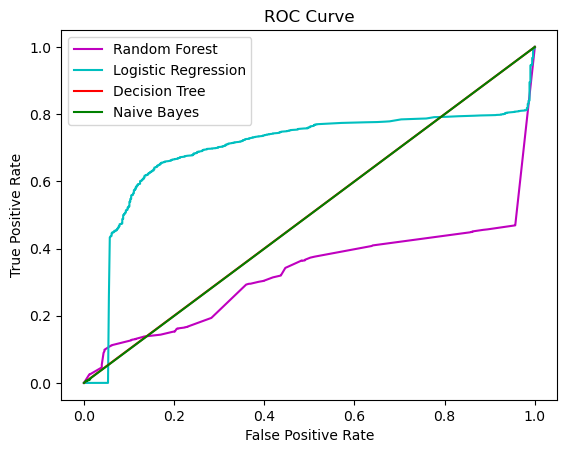

In [36]:
plt.title('ROC Curve')
plt.plot(d1[0], d1[1], color='m', label='Random Forest')
plt.plot(d2[0], d2[1], color='c', label='Logistic Regression')
plt.plot(d3[0], d3[1], color='r', label='Decision Tree')
plt.plot(d4[0], d4[1], color='g', label='Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

The table below indicates that the logistic regression has the highest accuracy and the largest AUC, reaching 0.79 and 0.70, respectively. The decision tree is also a competitive candidate regarding the F1 score. Generally speaking, except for the Naive Bayes, all models perform well-considering accuracy and F1 score since their values are about 0.7. Depending on which aspects we care more about, such as whether the sensitivity and specificity of a method are important to us, we may pick a different approach as the best choice. Naive Bayes did not perform well using either criterion. I think it has a poor forecast capability because it assumes each feature makes an independent and equal contribution to the outcome. However, this condition is not met in our case, as some attributes may be more prominent than others. The tree-based methods work well because, from my guess, I did not normalize the variables before training, and these methods can tolerate the considerable difference between the scale of variables.

In [41]:
accuracy = pd.DataFrame({
  'Models': ['Random Forest', 'Logistic Regression', 'Decision Tree', 'Naive Bayes'],
  'Accuracy': [acc_1, acc_2, acc_3, acc_4],
  'F1': [f1(pred1), f1(pred2), f1(pred3), f1(pred4)],
  'Area Under ROC': [integrate(d1[0], d1[1]), integrate(d2[0], d2[1]),
                     integrate(d3[0], d3[1]), integrate(d4[0], d4[1])],
   'Log Loss': [log1, log2, log3, 'NA']
})
accuracy

,Models,Accuracy,F1,Area Under ROC,Log Loss
0,Random Forest,0.772379,0.686771,0.326236,0.80713
1,Logistic Regression,0.786160,0.724771,0.694371,0.763897
2,Decision Tree,0.778751,0.735595,0.500023,2.13909
3,Naive Bayes,0.024706,0.046466,0.499616,NA


Logistic regression prefered the L2 (Ridge) penalty over the L1 (Lasso) penalty.

In [38]:
cvModel2.bestModel.getElasticNetParam()

0.0